In [ ]:
## LIBRERIAS
from google.colab import drive, files
import tensorflow as tf 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mlflow
from keras import Model, Sequential
from keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, BatchNormalization, Rescaling
import random
import os
random.seed(1234)

In [ ]:
## Cargamos Drive e importamos las imágenes de train y test
drive.mount('/content/drive')
!unzip "/content/drive/MyDrive/Colab/Sentinel2LULC_354.zip" -d "/content"
!unzip "/content/drive/MyDrive/Colab/Sentinel2LULC_Test.zip" -d "/content"

In [ ]:
## Renombramos las carpetas para que tf las lea en orden
dirnames = sorted(os.listdir("Sentinel2LULC_354"))
for dir in dirnames:
  newname = ""

  if (len(dir.split('_')[0]) == 1):
    newname = '0'+dir.split('_')[0]
  else:
    newname = dir.split('_')[0]

  os.rename("Sentinel2LULC_354/"+dir,"Sentinel2LULC_354/"+newname)

In [ ]:
## Leemos las imágenes de train, validacion y test
training = tf.keras.utils.image_dataset_from_directory(
  "Sentinel2LULC_354",
  validation_split=0.2,
  subset="training",
  seed=1234,
  image_size=(224, 224),
  batch_size = 32)

validation = tf.keras.utils.image_dataset_from_directory(
  "Sentinel2LULC_354",
  validation_split=0.2,
  subset="validation",
  seed=1234,
  image_size=(224, 224),
  batch_size = 32)

test = tf.keras.utils.image_dataset_from_directory(
  "Sentinel2LULC_Test",
  shuffle=False,
  labels=None,
  image_size=(224, 224),
  batch_size = 32)


Found 10266 files belonging to 29 classes.
Using 8213 files for training.
Found 10266 files belonging to 29 classes.
Using 2053 files for validation.
Found 1618 files belonging to 1 classes.


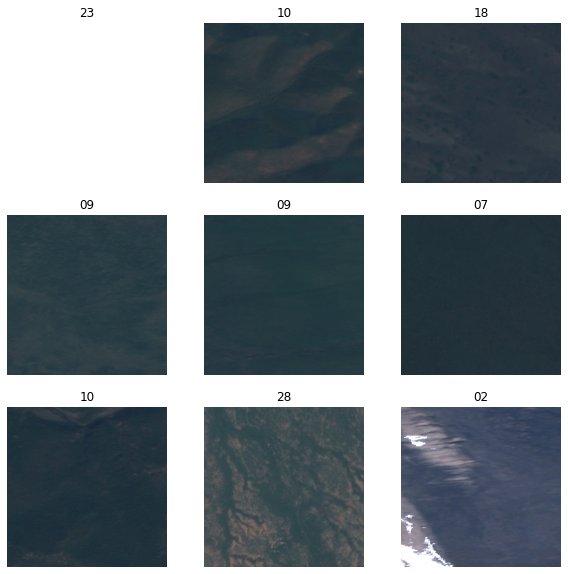

In [ ]:
## Mostramos las 9 primeras imagenes de training
class_names = training.class_names
plt.figure(figsize=(10, 10))
for images, labels in training.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

31801344/31790344 [==============================] - 0s 0us/step
Epoch 1/10
257/257 [==============================] - 31s 81ms/step - loss: 2.1289 - accuracy: 0.3121 - val_loss: 1.6264 - val_accuracy: 0.4340
Epoch 2/10
257/257 [==============================] - 21s 82ms/step - loss: 1.5091 - accuracy: 0.4786 - val_loss: 1.4356 - val_accuracy: 0.4978
Epoch 3/10
257/257 [==============================] - 20s 79ms/step - loss: 1.3434 - accuracy: 0.5368 - val_loss: 1.2735 - val_accuracy: 0.5621
Epoch 4/10
257/257 [==============================] - 21s 79ms/step - loss: 1.2028 - accuracy: 0.5878 - val_loss: 1.2449 - val_accuracy: 0.5582
Epoch 5/10
257/257 [==============================] - 20s 78ms/step - loss: 1.1126 - accuracy: 0.6234 - val_loss: 1.1441 - val_accuracy: 0.6186
Epoch 6/10
257/257 [==============================] - 20s 78ms/step - loss: 0.9795 - accuracy: 0.6637 - val_loss: 1.1947 - val_accuracy: 0.5943
Epoch 7/10
257/257 [==============================] - 20s 78ms/step - l

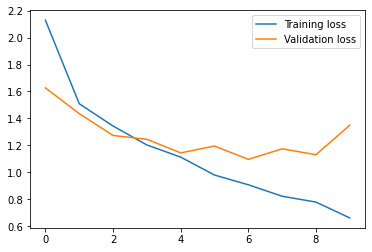

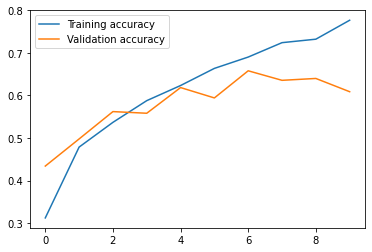

In [ ]:
## Función que muestra la evolución de las accuracy de train y validacion
## durante el entrenamiento.
def mostrarEvolucion(hist):

  loss = hist.history['loss']
  val_loss = hist.history['val_loss']
  plt.plot(loss)
  plt.plot(val_loss)
  plt.legend(['Training loss', 'Validation loss'])
  plt.show()

  acc = hist.history['accuracy']
  val_acc = hist.history['val_accuracy']
  plt.plot(acc)
  plt.plot(val_acc)
  plt.legend(['Training accuracy', 'Validation accuracy'])
  plt.show()

## Vamos a entrenar usando la red EfficietNetB2
base_model = tf.keras.applications.EfficientNetB2(input_shape=(224,224,3),
                                               include_top=False,
                                               weights='imagenet',
                                               pooling='avg')

normalization = Rescaling(1./255)
prediction_layer = Dense(29)

model = Sequential([
  normalization,
  base_model,
  prediction_layer
])

## Modelo de Juan Helios (prueba)
model2 = Sequential([
  tf.keras.layers.Rescaling(1./255, input_shape=(224,224,3)),
  tf.keras.layers.Conv2D(16, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(29)
])

opt = Adam()
      
model2.compile(loss=SparseCategoricalCrossentropy(from_logits=True),optimizer=opt, 
                  metrics=['accuracy'])

mlflow.set_experiment("Prueba")
mlflow.tensorflow.autolog()

with mlflow.start_run():
  callback = EarlyStopping(patience=3,restore_best_weights=True)
  history = model2.fit(training,
                    epochs=10,
                    validation_data=validation,
                    callbacks=callback)

  mostrarEvolucion(history)

In [ ]:
## Predecimos las clases
y_pred = model.predict(test)
classes = np.argmax(y_pred, axis=1)
classes = np.array(classes)
classes = classes + 1
print(classes)

[10 12  9 ...  9  6 26]


In [ ]:
## Creamos el csv con los resultados
d = {'id.jpg': sorted(os.listdir("Sentinel2LULC_Test")), 'label': classes}
df = pd.DataFrame(data=d)
df.to_csv('resultados.csv', index=False)